In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dists
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, multivariate_normal
from anesthetic.plot import kde_plot_1d, kde_contour_plot_2d
from torch_utils import get_limits
from np_utils import simple_data
from tension_net import TensionNet
from tension_quantify import BayesFactor, SuspiciousnessKLDiv, LogSuspiciousness

In [2]:
X0, X1, X_prior = simple_data()
X0_tensor = torch.tensor(X0, dtype=torch.float)
X1_tensor = torch.tensor(X1, dtype=torch.float)
X_prior_tensor = torch.tensor(X_prior, dtype=torch.float)

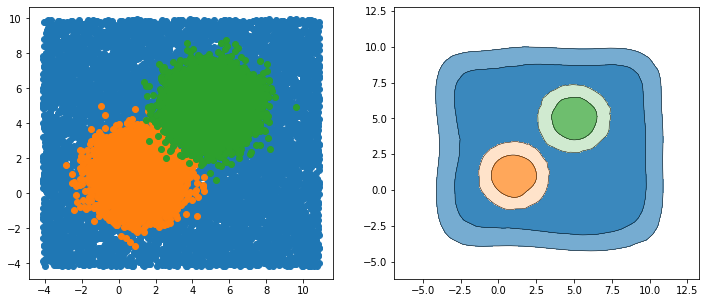

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(X_prior[:, 0], X_prior[:, 1])
axs[0].scatter(X0[:, 0], X0[:, 1])
axs[0].scatter(X1[:, 0], X1[:, 1])
kde_contour_plot_2d(axs[1], X_prior[:, 0], X_prior[:, 1])
kde_contour_plot_2d(axs[1], X0[:, 0], X0[:, 1])
kde_contour_plot_2d(axs[1], X1[:, 0], X1[:, 1])
plt.show()

## 1D Gaussian tension coordinate t

Neural network approach: let t = T(\theta; \alpha)

In [4]:
def test_tension_quantifier(method, XA, XB, X_prior=None):
    criterion = None    
    if method == "bayes":
        criterion = BayesFactor(hist_type="gaussian", hist_param=1, n_dist_bins=100, n_prior_bins=50)
    elif method == "log_suspiciousness_kldiv":
        criterion = SuspiciousnessKLDiv(n_dist_bins=100, n_prior_bins=50)
    elif method == "log_suspiciousness":
        criterion = LogSuspiciousness(torch.tensor(3), n_bins=50)

    thetas = np.linspace(0, 2 * np.pi, 50)
    tensions = []

    for theta in thetas:
        weight = torch.tensor([[np.cos(theta), np.sin(theta)]])
        tension_net = TensionNet(2)
        tension_net.state_dict()["linear.weight"].copy_(weight)
        tension_net.state_dict()["linear.bias"].copy_(torch.tensor([0]))
        XA_1d = tension_net(XA.float())
        XB_1d = tension_net(XB.float())

        tension_val = None
        if method == "bayes":
            X_prior_1d = tension_net(torch.tensor(X_prior).float())
            tension_val = torch.log(criterion(XA_1d, XB_1d, X_prior_1d))
        elif method == "log_suspiciousness_kldiv":
            X_prior_1d = tension_net(torch.tensor(X_prior).float())
            tension_val = criterion(XA_1d, XB_1d, X_prior_1d)
        elif method == "log_suspiciousness":
            tension_val = criterion(XA_1d, XB_1d)
        
        tensions.append(tension_val.item())

    return thetas, tensions

2.062023162841797


Text(0.5, 1.0, 'log S against theta')

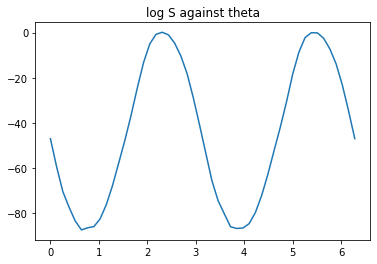

In [17]:
start = time.time()
theta, log_Ss = test_tension_quantifier("log_suspiciousness", X0_tensor, X1_tensor)
print(time.time() - start)
plt.plot(theta, log_Ss)
plt.title("log S against theta")

5.406285524368286


Text(0.5, 1.0, 'log R against theta')

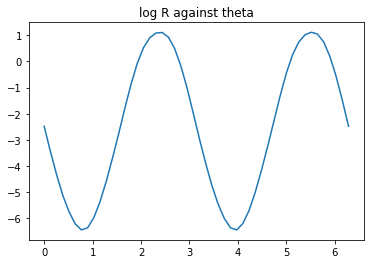

In [6]:
start = time.time()
thetas, Rs = test_tension_quantifier("bayes", X0_tensor, X1_tensor, X_prior=X_prior_tensor)
print(time.time() - start)
plt.plot(thetas, Rs)
plt.title("log R against theta")

6.166514873504639


Text(0.5, 1.0, 'log S against theta')

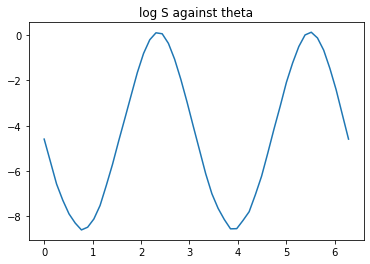

In [7]:
start = time.time()
thetas, log_Ss = test_tension_quantifier("log_suspiciousness_kldiv", X0_tensor, X1_tensor, X_prior=X_prior_tensor)
print(time.time() - start)
plt.plot(thetas, log_Ss)
plt.title("log S against theta")

### Try gradient descent

In [10]:
torch.tensor([112,43,5, -32]).clamp(-1, 1)


tensor([ 1,  1,  1, -1])

In [39]:
class WeightClipper(object):
    def __call__(self, module):
        if hasattr(module, 'linear') and hasattr(module.linear, 'weight'):
            w = module.linear.weight.data
            w = w.clamp(-1, 1)
            module.linear.weight.data = w


In [40]:
tension = TensionNet(2)
# tension.state_dict()["linear.weight"].copy_(torch.tensor([[-0.3, 0.6]]))
# tension.state_dict()["linear.bias"].copy_(torch.tensor([0]))
# criterion = BayesFactor(1000, n_dist_bins=200, n_prior_bins=50)
criterion = LogSuspiciousness(torch.tensor(3), n_bins=50)
optimizer = optim.SGD(tension.parameters(), lr=0.001)
clipper = WeightClipper()

losses = []
weights = torch.tensor([])
biases = torch.tensor([])
for i in range(200):
    optimizer.zero_grad()
    X0_1d = tension(X0_tensor)
    X1_1d = tension(X1_tensor)
    X_prior_1d = tension(X_prior_tensor)
    loss = criterion(X0_1d, X1_1d)
    losses.append(loss.item())
    weights = torch.cat((weights, tension.linear.weight))
    biases = torch.cat((biases, tension.linear.bias))
    loss.backward()
    optimizer.step()
    tension.apply(clipper)

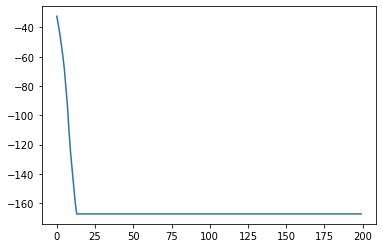

In [41]:
plt.plot(np.arange(200), losses)

In [42]:
tension.linear.weight

Parameter containing:
tensor([[-1., -1.]], requires_grad=True)

Parameter containing:
tensor([[-1., -1.]], requires_grad=True)


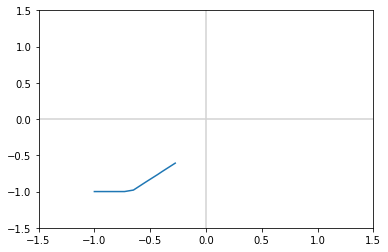

In [43]:
plt.plot(weights.detach().numpy()[:, 0], weights.detach().numpy()[:, 1])
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.axvline(0, color='lightgrey')
plt.axhline(0, color='lightgrey')

print(tension.linear.weight)